# Titanic - Machine Learning from Disaster (from Kaggle)

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

In [142]:
train_df = pd.read_csv('raw_data/train.csv')
test_df = pd.read_csv('raw_data/test.csv')
print(f'Training Set Shape: {train_df.shape}')
print(f'Test Set shape: {test_df.shape}')

Training Set Shape: (891, 12)
Test Set shape: (418, 11)


In [105]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's check for duplicated values first.

In [106]:
print(f'There are: {train_df.duplicated().sum()} duplicated rows.')

There are: 0 duplicated rows.


I don't think passenger id, passenger name, or ticket number will have any impact on outcomes. Let's drop these columns.

In [107]:
train_df = train_df.drop(columns=['PassengerId','Name', 'Ticket'])
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


Let's check for missing values next.

In [108]:
train_df.isna().sum().sort_values(ascending=False)/len(train_df)

Cabin       0.771044
Age         0.198653
Embarked    0.002245
Survived    0.000000
Pclass      0.000000
Sex         0.000000
SibSp       0.000000
Parch       0.000000
Fare        0.000000
dtype: float64

It seems like age, cabin, and embarked are the only columns missing values. For age, perhaps we can use a mean value after taking a look at the distribution. For cabin, let's see how many uniqe values we have. It may be worth dropping this column. For embarked, let's just fill with the most common value.

In [109]:
print(f"The cabin column contains {train_df['Cabin'].nunique()} unique values.")

The cabin column contains 147 unique values.


Since the Cabin colum is missing over 77% of its values and it contains 147 unique values, I don't think it is going to contribute much to our model. Let's go ahead and drop it.

In [110]:
train_df.drop(columns=['Cabin'], inplace=True)
train_df.shape

(891, 8)

<Axes: xlabel='Age', ylabel='Count'>

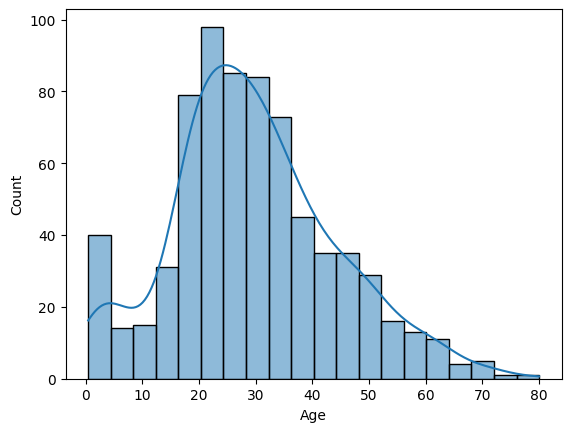

In [111]:
sns.histplot(train_df['Age'], kde=True)

Given the above age distribution, mean seems like a good strategy to fill in missing values for age.

In [112]:
# Column transformer to fill in missing age values with mean, missing embarked values with most frequent
# onehotencode sex and embarked columns

numeric_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse_output=False)
)

preprocessor = make_column_transformer(
  (numeric_transformer, ['Age', 'Fare']),
  (categorical_transformer, ['Sex','Embarked']), remainder='passthrough'
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Age', 'Fare']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['Sex', 'Embarked'])])

In [113]:
X= train_df.copy().drop(columns=['Survived'])
y = train_df['Survived']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape

(712, 7)

In [115]:
X_train_preprocesed = preprocessor.fit_transform(X_train)
X_train_preprocesed.shape

(712, 10)

In [116]:
print('Original Training Set')
display(X_train.head(3))
print('Preprocessed Training Set')
display(pd.DataFrame(X_train_preprocesed).head(3))

Original Training Set


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
671,1,male,31.0,1,0,52.0000,S
343,2,male,25.0,0,0,13.0000,S
258,1,female,35.0,0,0,512.3292,C


Preprocessed Training Set


,0,1,2,3,4,5,6,7,8,9
0,0.107196,0.372378,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
1,-0.358303,-0.375369,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0
2,0.417529,9.198260,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Now that we have a data preprocessor ready, let's get to modeling

In [119]:
# log_model = LogisticRegression()
# log_model.fit(X_train_preprocesed, y_train)
# log_model

In [121]:
cv_results = cross_validate(estimator=LogisticRegression(),
                    X=X_train_preprocesed,
                    y=y_train,
                    scoring='accuracy',
                    cv=5,
                    n_jobs=-1)

In [126]:
print(f"Mean accuracy score: {cv_results['test_score'].mean()}")

Mean accuracy score: 0.8160445188614203


Let's try tweaking a few hyperparameters to see if we can get better results.

In [128]:
search_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs', 'saga']
}

In [134]:
search = GridSearchCV(
    LogisticRegression(max_iter=10000),
    search_params,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

In [135]:
search.fit(X_train_preprocesed, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'solver': ['liblinear', 'lbfgs', 'saga']},
             scoring='accuracy')

In [136]:
search.best_score_

0.8202895695853443

In [137]:
search.best_params_

{'C': 0.1, 'solver': 'lbfgs'}

In [138]:
best_log = search.best_estimator_
best_log

LogisticRegression(C=0.1, max_iter=10000)

In [139]:
best_log.score(preprocessor.fit_transform(X_test), y_test)

0.7262569832402235

It looks like we are overfitting. Training data has accuracy of 82%, whereas test data is only 73%.

Let's go ahead and make predictions using this model and submit to Kaggle to see the results.

In [143]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [146]:
kaggle_test = test_df.copy().drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
kaggle_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [148]:
kaggle_test_processed = preprocessor.transform(kaggle_test)
pd.DataFrame(kaggle_test_processed)

,0,1,2,3,4,5,6,7,8,9
0,3.339417e-01,-0.600055,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0
1,1.266666e+00,-0.621794,1.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0
2,2.385936e+00,-0.551336,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0
3,-2.256931e-01,-0.578208,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0
4,-5.987830e-01,-0.483172,1.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
413,-2.650963e-16,-0.594266,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0
414,6.697226e-01,2.049694,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
415,6.324136e-01,-0.615239,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0
416,-2.650963e-16,-0.594266,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0


In [149]:
predictions = best_log.predict(kaggle_test_processed)

In [158]:
submission = pd.DataFrame({'PassengerID':test_df['PassengerId'],'Survived':predictions})
submission.set_index('PassengerID', inplace=True)
submission.head()

,Survived
PassengerID,
892,0
893,0
894,0
895,0
896,1


In [160]:
submission.to_csv('raw_data/kaggle_submission.csv', header=True)